In [94]:
def compute_average_loss(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)
    return (total_loss / total_samples)

def compute_differentiable_average_loss(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    losses = []
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        losses.append(loss * data.size(0))
        total_samples += data.size(0)
    total_loss = sum(losses) / total_samples
    return total_loss

def get_perturbation_randn(named_params, keys, epsilon):
    perturbations = {}
    for name, param in named_params:
        if name in keys:
            perturbations[name] = epsilon * torch.randn_like(param)
        else:
            perturbations[name] = torch.zeros_like(param)
    return perturbations

def get_perturbation_remove_percentage(named_params, keys, percentage):
    perturbations = {}
    for name, param in named_params:
        if name in keys:
            mask = (torch.rand_like(param) < percentage).float()
            perturbations[name] = - param * mask
        else:
            perturbations[name] = torch.zeros_like(param)
    return perturbations

def get_perturbation_remove_columns(named_params, keys, percentage):
    perturbations = {}
    for name, param in named_params:
        if name in keys and param.dim() == 4:
            num_channels = param.size(0)
            num_remove = int(round(percentage * num_channels))
            if num_remove <= 0:
                perturbations[name] = torch.zeros_like(param)
            else:
                remove_indices = random.sample(range(num_channels), num_remove)
                mask = torch.ones_like(param)
                mask[remove_indices, :, :, :] = 0.0
                perturbations[name] = -param * (1 - mask)
        elif name in keys and param.dim() == 2:
            num_columns = param.size(1)
            num_remove = int(round(percentage * num_columns))
            if num_remove <= 0:
                perturbations[name] = torch.zeros_like(param)
            else:
                remove_indices = random.sample(range(num_columns), num_remove)
                mask = torch.ones_like(param)
                mask[:, remove_indices] = 0.0
                perturbations[name] = -param * (1 - mask)
        else:
            perturbations[name] = torch.zeros_like(param)
    return perturbations

def get_perturbation_leave_rank(named_params, keys, up_to_percent):
    perturbations = {}

    for name, param in named_params:
        if name in keys:
            if param.dim() == 4:
                cout, cin, h, w = param.shape
                reshaped_param = param.view(cout, -1)
                U, S, Vh = torch.svd(reshaped_param)
                Vh = Vh.T
                m, n = cout, cin * h * w
                up_to = int(max((min(m, n) * up_to_percent), 1))
                S = S.clone()
                S = S[:up_to]
                Vh = Vh[:up_to, :]
                U = U[:, :up_to]
                perturbed_param = U @ torch.diag(S) @ Vh
                perturbations[name] = (perturbed_param - reshaped_param).view(cout, cin, h, w)

            elif param.dim() == 2:
                U, S, Vh = torch.svd(param)
                Vh = Vh.T
                m, n = param.shape
                up_to = max(int(min(m, n) * up_to_percent), 1)
                S = S.clone()
                S = S[:up_to]
                Vh = Vh[:up_to, :]
                U = U[:, :up_to]
                perturbed_param = U @ torch.diag(S) @ Vh
                #print(perturbed_param.shape, param.shape, S.shape, Vh.shape, U.shape)
                perturbations[name] = perturbed_param - param
            else:
                perturbations[name] = torch.zeros_like(param)
        else:
            perturbations[name] = torch.zeros_like(param)

    return perturbations



In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)


transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
eval_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for i in range(4):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
print("Training loss (last batch):", loss.item())

Training loss (last batch): 0.2185192108154297


In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)


transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
eval_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for i in range(2):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
print("Training loss (last batch):", loss.item())

Training loss (last batch): 0.05938582122325897


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
eval_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for i in range(2):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
print("Training loss (last batch):", loss.item())



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training loss (last batch): 0.04490542411804199


['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias']


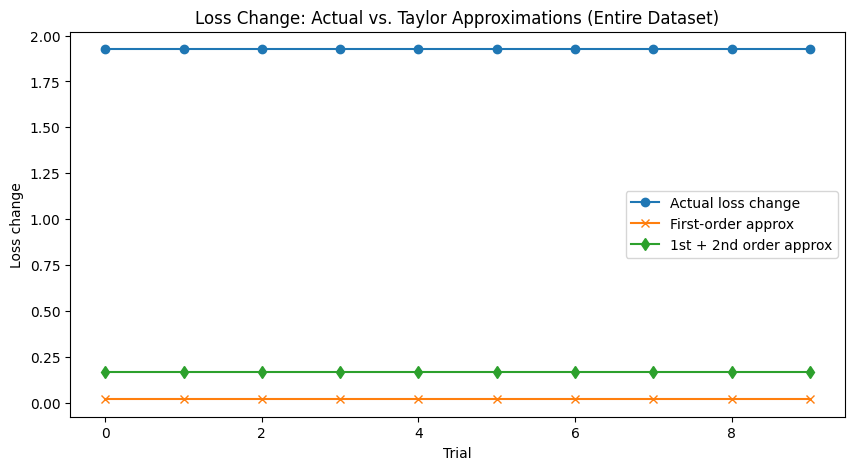

In [100]:


num_trials = 10
epsilon = 1e-4

actual_changes = []
first_order_terms = []
second_order_terms = []
taylor_predictions = []

named_params = list(model.named_parameters())
print([name for name, _ in named_params])
params = [p for _, p in named_params]

eval_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:1024]), batch_size=1024, shuffle=False)
baseline_loss_value = compute_average_loss(model, eval_loader, criterion, device)

baseline_loss = torch.tensor(baseline_loss_value).to(device)
param_keys = [name for name, _ in named_params]
for i in range(num_trials):
    model.train()
    loss = compute_differentiable_average_loss(model, eval_loader, criterion, device)

    grads = torch.autograd.grad(loss, params, create_graph=True)

    #named_deltas = get_perturbation_randn(named_params, [name for name, _ in named_params], epsilon)
    #named_deltas = get_perturbation_remove_percentage(named_params, ["fc.weight"], 0.01)
    #named_deltas = get_perturbation_remove_columns(named_params, ["conv1.weight"], 0.05)
    named_deltas = get_perturbation_leave_rank(named_params, ["fc1.weight"], 0)
    deltas = [d for _, d in named_deltas.items()]

    first_order = sum(torch.sum(g * d) for g, d in zip(grads, deltas))

    hessian_vec = torch.autograd.grad(first_order, params, retain_graph=True)
    second_order = 0.5 * sum(torch.sum(hv * d) for hv, d in zip(hessian_vec, deltas))

    taylor_pred = first_order + second_order

    original_params = [p.clone() for p in params]

    with torch.no_grad():
        for p, d in zip(params, deltas):

            p.add_(d)

    perturbed_loss_value = compute_average_loss(model, eval_loader, criterion, device)
    actual_change = perturbed_loss_value - baseline_loss_value

    with torch.no_grad():
        for p, orig in zip(params, original_params):
            p.copy_(orig)

    actual_changes.append(actual_change)
    first_order_terms.append(first_order.item())
    second_order_terms.append(second_order.item())
    taylor_predictions.append(taylor_pred.item())

plt.figure(figsize=(10, 5))
plt.plot(range(num_trials), actual_changes, label="Actual loss change", marker='o')
plt.plot(range(num_trials), first_order_terms, label="First-order approx", marker='x')
plt.plot(range(num_trials), taylor_predictions, label="1st + 2nd order approx", marker='d')
plt.xlabel("Trial")
plt.ylabel("Loss change")
plt.title("Loss Change: Actual vs. Taylor Approximations (Entire Dataset)")
plt.legend()
plt.show()